In [1]:
'''
Analysis of /r/nba Posts
@author: Brian Lin
'''
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import scipy.stats as stats
from scipy.optimize import minimize
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures

In [2]:
def return_csv_files(path):
    pattern = r'^.*\.csv$'
    return [f for f in os.listdir(path) if bool(re.match(pattern,f))]
    
path = '../data/backlog/'
csv_files = return_csv_files(path)
df = pd.DataFrame()
for csv in csv_files:
    csv_df = pd.read_csv(path + csv)
    df = pd.concat([df,csv_df])
df['created'] = pd.to_datetime(df.created, unit = 's')
df.index = range(0,len(df))
# 18,001 total examples with no duplicates

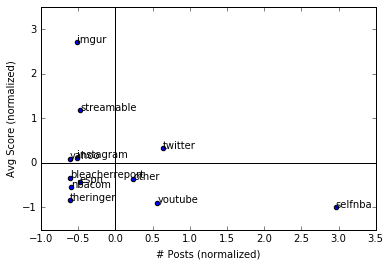

In [3]:
'''
How Domains affect score and number of posts
'''
top_domains = ['selfnba', 'twitter','youtube','streamable','instagram','espn','imgur','nbacom','theringer','yahoo','bleacherreport']
domain_df = pd.DataFrame()
domains = df.domain.apply(lambda d: ''.join(d.split('.')))

def strip_domain(d):
    for td in top_domains:
        if td in d:
            return td
    return 'other'


domain_df['domain'] = domains.apply(strip_domain)
domain_df['score'] = df.score
for td in top_domains:
    domain_df[td] = domains.apply(lambda d: 1 if td in d else 0)
    
def normalize(column):
    mean = np.mean(column)
    sd = np.std(column)
    return column.apply(lambda d: (d-mean)/sd)

def plot_normalized_scatter(x,y,labels):
    fig, ax = plt.subplots()
    ax.scatter(x,y)
    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i],y[i]))
    plt.plot([0,0], [-5,5], color='k')
    plt.plot([5,-5], [0,0], color='k')
    plt.xlim(-1, 3.5)
    plt.ylim(-1.5, 3.5)
    plt.ylabel('Avg Score (normalized)')
    plt.xlabel('# Posts (normalized)')
    

norm_domain_df = domain_df.groupby('domain').agg({'score':[np.mean,np.size]}).apply(normalize)
x = norm_domain_df['score']['size']
y = norm_domain_df['score']['mean']
n = norm_domain_df.index

plot_normalized_scatter(x,y,n)

In [4]:
def front_page_or_not(score,flag = 0):
    # karma >= 150 = front_page, s = 1
    # 150 > karma >= 50 = iffy, s = 0.5
    # 50 > karma = not front_page, s = 0
    if score >= 150:
        return 1
    elif score >= 50:
        if flag == 1:
            return 1
        else:
            return 0.5
    else:
        return 0

front_page_ser = df.score.apply(front_page_or_not)
#front_page_ser.value_counts()
df.score.describe()

count    18001.000000
mean       210.539970
std        548.597572
min          0.000000
25%          6.000000
50%         27.000000
75%        144.000000
max       6296.000000
Name: score, dtype: float64

0.332884817554


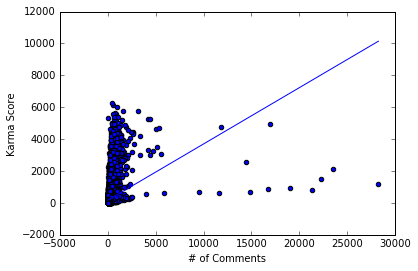

In [5]:
r = np.corrcoef(df.num_comments,df.score)[0][1]
b = df.score.std()/df.num_comments.std() * r
a = df.score.mean() - df.num_comments.mean()*b

plt.scatter(df.num_comments, df.score)
plt.plot([df.num_comments.min(),df.num_comments.max()],[df.num_comments.min()*b + a,df.num_comments.max()*b + a])
plt.xlabel('# of Comments')
plt.ylabel('Karma Score')
print r

In [6]:
def prediction_score(predicted_p, Y,threshold=0.5):
    def greater_than_one_half(x):
        if x > threshold:
            return 1
        else:
            return 0
        
    predicted_Y = np.array([greater_than_one_half(x) for x in predicted_p])
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(len(predicted_Y)):
        if predicted_Y[i] == 1 and Y[i] == 1:
            true_pos +=1
        elif predicted_Y[i] == 1 and Y[i] == 0:
            false_pos +=1
        elif predicted_Y[i] == 0 and Y[i] == 1:
            true_neg +=1
        elif predicted_Y[i] == 0 and Y[i] == 0:
            false_neg +=1
    
    wrong = float(np.sum(np.abs(predicted_Y - Y)))
    total = float(len(predicted_Y))
    ans = dict()
    ans['accuracy'] =  1-(wrong/total)
    ans['true_pos'] = true_pos
    ans['true_neg'] = true_neg
    ans['false_pos'] = false_pos
    ans['false_neg'] = false_neg
    if true_pos == 0 and false_pos == 0:
        ans['recall'] = float(true_pos) / float((true_pos + true_neg))
    elif true_pos == 0 and true_neg == 0:
        ans['precision'] = float(true_pos) / float((true_pos + false_pos))
    else:
        ans['precision'] = float(true_pos) / float((true_pos + false_pos))
        ans['recall'] = float(true_pos) / float((true_pos + true_neg))
        ans['f1_score'] = 2 * ans['precision'] * ans['recall'] / (ans['precision'] + ans['recall'] )
    return ans

/Users/brianlin/anaconda/lib/python2.7/site-packages/scipy/optimize/_minimize.py:381: RuntimeWarning: Method Nelder-Mead does not use gradient information (jac).
  RuntimeWarning)


[]

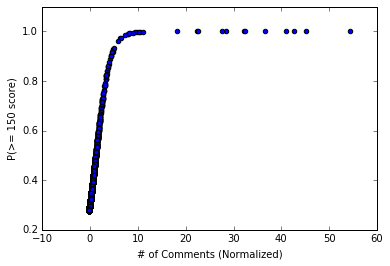

In [7]:
def front_page(score,n=150):
    if score >= n:
        return 1
    else:
        return 0

def sigmoid(z):
    return np.power(1 + np.exp(-z), -1)

def logistic_cost_regularized(theta, Xdata, Ydata, lam=1):
    # NB Xdata must be a numpy array

    m = float(len(Xdata))
    
    J = (
        - 1/m * (np.log(sigmoid(Xdata.dot(theta))).dot(Ydata) + 
        np.log(1-sigmoid(Xdata.dot(theta))).dot(1-Ydata) ) + 
        lam/(2*m) * np.sum(theta[1:] ** 2) 
        )
    if np.isnan(J):
        return(np.inf)
    return(J)

def logistic_grad_regularized(theta, Xdata, Ydata, lam=1):
    # NB Xdata must be a numpy array
    m = float(len(Xdata))
    
    grad = theta.copy() * lam
    grad[0] = 0
    grad += Xdata.T.dot(sigmoid(Xdata.dot(theta))-Ydata)
    grad *= 1/m 
    
    return grad 

X = normalize(df.num_comments)
Y = df.score.apply(front_page)
poly = PolynomialFeatures(1)
X_Transformed = poly.fit_transform(X.values.reshape(len(X),1))
Y = Y.values
theta = np.zeros((X_Transformed.shape[1],))
res = minimize(logistic_cost_regularized, theta, args=(X_Transformed,Y), method = 'Nelder-Mead', jac=logistic_grad_regularized, options={'maxiter':400})

predicted_Y = np.array(sigmoid(X_Transformed.dot(res.x)))

plt.scatter(X, sigmoid(X_Transformed.dot(res.x)))
plt.xlabel('# of Comments (Normalized)')
plt.ylabel('P(>= 150 score)')
plt.plot()

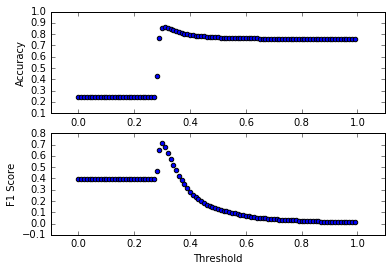

In [8]:

score_df = pd.DataFrame()
accuracy_scores_df = []
for threshold_val in np.arange(0.0,1.0,0.01):
    p_score = prediction_score(predicted_Y, Y, threshold_val)
    p_score['threshold'] = threshold_val
    accuracy_scores_df.append(p_score)
a_df = pd.DataFrame(accuracy_scores_df)

fig = plt.figure()
ax1 = fig.add_subplot(211)

ax1.scatter(x = a_df['threshold'], y=a_df['accuracy'])
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(-.1,1.1)

ax2 = fig.add_subplot(212)

ax2.scatter(x = a_df['threshold'], y=a_df['f1_score'])
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1 Score')
ax2.set_xlim(-.1,1.1)

plt.show()

In [9]:
# WITH ONLY NUM COMMENTS
# If Threshold is .25, accuracy is .86, f1_score is .66
pd.concat([a_df.iloc[a_df.accuracy.argmax()], a_df.iloc[a_df.f1_score.argmax()]], axis =1)

,31,30
accuracy,0.863341,0.854564
f1_score,0.682253,0.712813
false_neg,12900.000000,12134.000000
false_pos,694.000000,1460.000000
precision,0.791904,0.689955
recall,0.599274,0.737236
threshold,0.310000,0.300000
true_neg,1766.000000,1158.000000
true_pos,2641.000000,3249.000000


In [10]:
num_comments_logit_df =  pd.concat([pd.DataFrame(X.values, columns= ["X"]),pd.DataFrame(predicted_Y, columns= ["Y"])], axis=1)
num_comments_logit_df[num_comments_logit_df.Y > .25].sort_values(by="X").iloc[0]

X   -0.205421
Y    0.277096
Name: 15041, dtype: float64

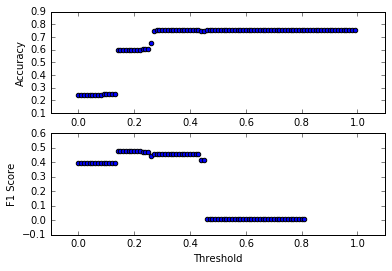

In [11]:
'''
Using Domain and num comments to predict front page
'''

x_data = domain_df.iloc[:,2:]
#x_data = pd.concat([x_data,df.num_comments], axis = 1)
#x_data['num_comments'] = normalize(x_data['num_comments'])
Y1 = df.score.apply(front_page)
poly1 = PolynomialFeatures(1)
X_Transformed1 = poly1.fit_transform(x_data.values)

theta1 = np.zeros((X_Transformed1.shape[1],))
res1 = minimize(logistic_cost_regularized, theta1, args=(X_Transformed1,Y1.values), 
                method = 'Nelder-Mead', jac=logistic_grad_regularized, options={'maxiter':400})
predicted_Y1 = np.array(sigmoid(X_Transformed1.dot(res1.x)))
accuracy_scores_df1 = []
for threshold_val in np.arange(0.0,1.0,0.01):
    p_score = prediction_score(predicted_Y1, Y1.values, threshold_val)
    p_score['threshold'] = threshold_val
    accuracy_scores_df1.append(p_score)
a_df1 = pd.DataFrame(accuracy_scores_df1)
a_df1


fig = plt.figure()
ax1 = fig.add_subplot(211)

ax1.scatter(x = a_df1['threshold'], y=a_df1['accuracy'])
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(-.1,1.1)
ax2 = fig.add_subplot(212)

ax2.scatter(x = a_df1['threshold'], y=a_df1['f1_score'])
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1 Score')
ax2.set_xlim(-.1,1.1)

plt.show()

In [12]:
# WITH DOMAIN FEATURES
pd.concat([a_df1.iloc[a_df1.accuracy.argmax()], a_df1.iloc[a_df1.f1_score.argmax()]], axis =1)

,82,14
accuracy,0.75518,0.594745
f1_score,NaN,0.479412
false_neg,13594.00000,7347.000000
false_pos,0.00000,6247.000000
precision,NaN,0.349677
recall,0.00000,0.762197
threshold,0.82000,0.140000
true_neg,4407.00000,1048.000000
true_pos,0.00000,3359.000000


In [13]:
'''
Predicting P(>= 150 Score) based on title using Naive Bayes
'''

# List of most common words
common_words = pd.read_csv('../lib/common_words.txt', header = None)[0]
def remove_common_words(title, common_words):
    tw = map(lambda d: d.strip(".,:()!?\"").lower(),title.split())
    return [w for w in tw if w not in common_words]

# Looking to see most common words in all titles
title_s = df.title
title_words = []
for title in title_s:
    title_words.extend(remove_common_words(title, common_words))
title_words_s = pd.Series(title_words)
title_words_s = title_words_s[~title_words_s.isin(common_words)]

# removing prepositions and useless words
title_s = title_s.apply(lambda d: remove_common_words(d, common_words))
title_df = pd.concat([title_s, df.score], axis = 1).head()

title_df_encoded = pd.DataFrame(title_s)

In [14]:
tw_unique = title_words_s.unique()

def create_feature_row(title, word_vec):
    feature_row = np.zeros((len(word_vec),))
    for word in title:
        if word in word_vec:
            word_index = np.where(word_vec==word)[0][0]
            feature_row[word_index] = 1
    return feature_row

In [15]:
def iterate(top_words = None, n=1000):
    l = []
    if top_words is None:
        top_words = title_words_s.value_counts()[:n].index
    for row in title_s:
        l.append(create_feature_row(row, top_words))
    return l
    
title_features_df = pd.DataFrame(iterate())
#title_features_df = pd.DataFrame(iterate(word_bank_s))
title_features_df.head()

sum(title_features_df.sum(axis =1) == 0)

261

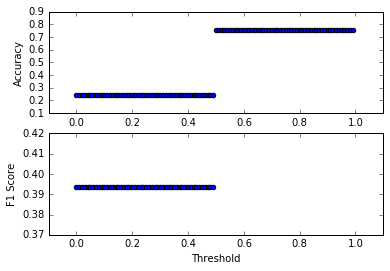

In [16]:
X2 = pd.concat([pd.DataFrame(np.ones(len(title_features_df))),title_features_df], axis=1)
theta2 = np.zeros((X2.shape[1],))
res2 = minimize(logistic_cost_regularized, theta2, args=(X2.values,Y1.values), 
                method = 'Nelder-Mead', jac=logistic_grad_regularized, options={'maxiter':400})

predicted_Y2 = np.array(sigmoid(X2.dot(res2.x)))
accuracy_scores_df2 = []
for threshold_val in np.arange(0.0,1.0,0.01):
    p_score = prediction_score(predicted_Y2, Y1.values, threshold_val)
    p_score['threshold'] = threshold_val
    accuracy_scores_df2.append(p_score)
a_df2 = pd.DataFrame(accuracy_scores_df2)


fig = plt.figure()
ax1 = fig.add_subplot(211)

ax1.scatter(x = a_df2['threshold'], y=a_df2['accuracy'])
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')
ax1.set_xlim(-.1,1.1)

ax2 = fig.add_subplot(212)

ax2.scatter(x = a_df2['threshold'], y=a_df2['f1_score'])
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1 Score')
ax2.set_xlim(-.1,1.1)

plt.show()

In [17]:
pd.concat([a_df2.iloc[a_df2.accuracy.argmax()], a_df2.iloc[a_df2.f1_score.argmax()]], axis =1)

,50,0
accuracy,0.75518,0.244820
f1_score,NaN,0.393342
false_neg,13594.00000,0.000000
false_pos,0.00000,13594.000000
precision,NaN,0.244820
recall,0.00000,1.000000
threshold,0.50000,0.000000
true_neg,4407.00000,0.000000
true_pos,0.00000,4407.000000


In [18]:
#Generates the feature word vectors

title_s1 = df.title
title_words1 = []
score_tw1 = []
for i in range(len(title_s1)):
    title_word_list = remove_common_words(title_s1.iloc[i], common_words)
    title_words1.extend(title_word_list)
    score_tw1.extend([df.score.iloc[i]]* len(title_word_list))
title_words_s1 = pd.Series(title_words1)
#title_words_s1 = title_words_s[~title_words_s.isin(common_words)]
scores_by_word = pd.concat([title_words_s1,pd.Series(score_tw1)],axis=1).groupby(0).agg(['mean', 'count','std',np.median])
scores_by_word15 = scores_by_word[~scores_by_word.index.isin(common_words) & (scores_by_word[1,'count'] > 10)]

# computing the p value only works if its a normal distribution which it isn't. 
# Thats why I decided to sort by median instead
def compute_p_greater_n(mean,count,std,n):
    z = (n-mean)/(std)
    return 1- stats.t.cdf(z,count)

scores_by_word15['p_greater_150'] = scores_by_word15.apply(lambda d: compute_p_greater_n(d[1]['mean'],d[1]['count'],d[1]['std'],150), axis=1)
word_bank = pd.concat([scores_by_word15.sort_values(by=[(1,'median')],ascending=False)[:200],scores_by_word15.sort_values(by=[(1,'median')],ascending=False)[-200:]])
word_bank_s = np.array(word_bank.index)

#title_features_bayes_df = pd.DataFrame(iterate()) # 1000 most common words
title_features_bayes_df = pd.DataFrame(iterate(word_bank_s))

/Users/brianlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [19]:
# Caches the p(y) for all y and p(x|y) probabilities for all words- takes around 1-2 minutes to run 

py1 = float((Y1.values == 1).sum())/len(Y1)
py0 = float((Y1.values == 0).sum())/len(Y1)

bayes_y1_table = []
bayes_y0_table = []
deny1 = float((Y1.values == 1).sum())+2
deny0 = float((Y1.values == 0).sum())+2
feature_len = len(title_features_bayes_df.columns)/10
for i in range(len(title_features_bayes_df.columns)):
    numy1 = ((title_features_bayes_df[i] == 1).values & (Y1.values == 1)).sum()+1
    numy0 = ((title_features_bayes_df[i] == 1).values & (Y1.values == 0)).sum()+1
    bayes_y1_table.append(numy1/deny1)
    bayes_y0_table.append(numy0/deny0)
    if i % feature_len == 0:
        print '{0}% done'.format(i/(feature_len/10))
print'done'

0% done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
done


In [20]:
# Takes around 7 minutes to run

Y_predicted3 = []
for w_index in range(len(title_features_bayes_df)):
    row_1 = title_features_bayes_df.iloc[w_index]
    title_p1 = 1.0
    title_p0 = 1.0
    for i in range(len(row_1)):
        if row_1[i] == 1:
            title_p1 *= bayes_y1_table[i]
            title_p0 *= bayes_y0_table[i]
    Y_predicted3.append(1 if title_p1*py1 > title_p0*py0 else 0)
    if w_index % 1800 == 0:
        print "{0}% done".format(w_index/180)
print'done'

0% done
10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done
done


In [21]:
# Benchmark of using Num Comments to predict it
'''
accuracy         0.854564
f1_score         0.712813
false_neg    12134.000000
false_pos     1460.000000
precision        0.689955
recall           0.737236
threshold        0.300000
true_neg      1158.000000
true_pos      3249.000000
'''

#Description: trained with 1000 most common words. count > 15
'''
{'accuracy': 0.6828509527248486,
 'f1_score': 0.5113412650860224,
 'false_neg': 9305,
 'false_pos': 4289,
 'precision': 0.4105277625068719,
 'recall': 0.6777853415021556,
 'true_neg': 1420,
 'true_pos': 2987}
'''

# Desription: trained with 1000 most likely words to have score over 150 assuming normal distribution. count > 15

'''
{'accuracy': 0.5905783012054886,
 'f1_score': 0.49200441135925005,
 'false_neg': 7062,
 'false_pos': 6532,
 'precision': 0.35333135333135335,
 'recall': 0.8098479691400046,
 'true_neg': 838,
 'true_pos': 3569}
'''

#Description: 300 words with highest median. count > 15
'''
{'accuracy': 0.7484028665074163,
 'f1_score': 0.47948511665325827,
 'false_neg': 11386,
 'false_pos': 2208,
 'precision': 0.48579413134606425,
 'recall': 0.4733378715679601,
 'true_neg': 2321,
 'true_pos': 2086}
'''

#Description: 200 words with highest median + 200 words with lowest median. count > 20
'''

{'accuracy': 0.7625687461807678,
 'f1_score': 0.4398427260812582,
 'false_neg': 12049,
 'false_pos': 1545,
 'precision': 0.5206329506670804,
 'recall': 0.38075788518266396,
 'true_neg': 2729,
 'true_pos': 1678}
 
 count 15
{'accuracy': 0.7669573912560413,
 'f1_score': 0.44678886984043253,
 'false_neg': 12112,
 'false_pos': 1482,
 'precision': 0.533375314861461,
 'recall': 0.3843884728840481,
 'true_neg': 2713,
 'true_pos': 1694} 
 
 count > 10
 {'accuracy': 0.7747347369590578,
 'f1_score': 0.45401911942911,
 'false_neg': 12260,
 'false_pos': 1334,
 'precision': 0.5582781456953643,
 'recall': 0.382573179033356,
 'true_neg': 2721,
 'true_pos': 1686}
 
'''

predicted_Y3 = np.array(Y_predicted3)
p_score = prediction_score(predicted_Y3, Y1.values)
p_score

{'accuracy': 0.7757346814065885,
 'f1_score': 0.4551221487380213,
 'false_neg': 12278,
 'false_pos': 1316,
 'precision': 0.5616255829447035,
 'recall': 0.382573179033356,
 'true_neg': 2721,
 'true_pos': 1686}

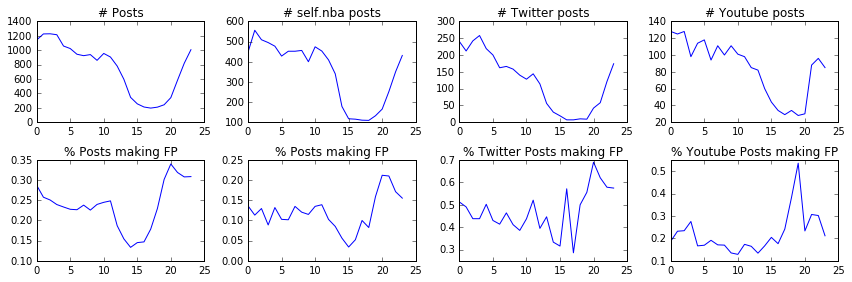

In [22]:
'''
Analysis to Determine if Time of Day determines how likely a post will make the front page.
If you find the right time to post (between 16-20)
'''

def fp_per_hour(domain= None, fp=True):
    # returns percent of posts that make front page per hour
    s0 = None
    s1 = None
    if domain == None:
        s0 = (df[(Y1.values == 0)].created.apply(lambda d: d.hour))
        s1 = (df[(Y1.values == 1)].created.apply(lambda d: d.hour))
        sall = (df.created.apply(lambda d: d.hour))
    else:
        s0 = (df[(Y1.values == 0) & (df.domain == domain)].created.apply(lambda d: d.hour))
        s1 = (df[(Y1.values == 1) & (df.domain == domain)].created.apply(lambda d: d.hour))
        sall = (df[df.domain == domain].created.apply(lambda d: d.hour))
    s0 = (s0.groupby(s0).size())
    s1 = (s1.groupby(s1).size())
    sall = sall.groupby(sall).size()
    if fp:
        return s1/sall
    else:
        return sall


fig = plt.figure()
ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8 = (fig.add_subplot(241), fig.add_subplot(242), fig.add_subplot(243), fig.add_subplot(244), 
                           fig.add_subplot(245), fig.add_subplot(246), fig.add_subplot(247), fig.add_subplot(248))
fig.set_figheight(4)
fig.set_figwidth(12)
ax1.plot(fp_per_hour(None, False))
ax1.set_title('# Posts')
ax5.plot(fp_per_hour())
ax5.set_title('% Posts making FP')

ax2.plot(fp_per_hour('self.nba', False))
ax2.set_title('# self.nba posts')
ax6.plot(fp_per_hour('self.nba'))
ax6.set_title('% Posts making FP')

ax3.plot(fp_per_hour('twitter.com', False))
ax3.set_title('# Twitter posts')
ax7.plot(fp_per_hour('twitter.com'))
ax7.set_title('% Twitter Posts making FP')
                                   
ax4.plot(fp_per_hour('youtube.com', False))
ax4.set_title('# Youtube posts')
ax8.plot(fp_per_hour('youtube.com'))
ax8.set_title('% Youtube Posts making FP')
                                   
fig.tight_layout()